# **Análisis de la temporada 2019-2020 de la NBA para LAL, LAC, DEN, HOU.** 
---
<img src="logoNBA.png" width=700 height=900 /> 

## Importando librerias y cargando los datos a usar obtenidos en https://www.kaggle.com/schmadam97/nba-playbyplay-data-20182019?select=NBA_PBP_2019-20.csv

In [1]:
import numpy as np #Librería numérica
import pandas as pd #librería para el análisis y manipulación de datos
import matplotlib as mpl
from matplotlib import pyplot as plt #Librería gráfica
import seaborn as sns #Librería gráfica de complementación
from simple_colors import * #Imprimir con colores

In [2]:
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)

## Definiendo una función que será de utilidad a la hora de graficar:

In [3]:
def barPerc(df,xVar,ax): #Agregar un porcentaje de matices a los gráficos de barras
    numX=len([x for x in df[xVar].unique() if x==x])

    bars = ax.patches

    for ind in range(numX):
    
        hueBars=bars[ind:][::numX]
        ## Obtiene la altura total para los porcentajes
        total = sum([x.get_height() for x in hueBars])

        # Imprime el porcentaje de las barras
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

## Cargando y viendo las columnas del DataSet original:

In [4]:
df_original=pd.read_csv('NBA_PBP_2019-20.csv') # Archivo descargado previamente en el pc
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539265 entries, 0 to 539264
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   URL                 539265 non-null  object 
 1   GameType            539265 non-null  object 
 2   Location            539265 non-null  object 
 3   Date                539265 non-null  object 
 4   Time                539265 non-null  object 
 5   WinningTeam         539265 non-null  object 
 6   Quarter             539265 non-null  int64  
 7   SecLeft             539265 non-null  int64  
 8   AwayTeam            539265 non-null  object 
 9   AwayPlay            272389 non-null  object 
 10  AwayScore           539265 non-null  int64  
 11  HomeTeam            539265 non-null  object 
 12  HomePlay            266868 non-null  object 
 13  HomeScore           539265 non-null  int64  
 14  Shooter             202397 non-null  object 
 15  ShotType            202397 non-nul

### Dado a que cada evento es único se procede a eliminar las filas que sean completamente iguales debido a posibles errores de digitación:

In [5]:
df_sin_duplicados= df_original.drop_duplicates()

## Seleccionando los partidos regulares y las columnas necesarias para el análisis:

In [6]:
df_sin_duplicados=df_sin_duplicados[df_sin_duplicados['GameType']=='regular']

Columnas = ['Time','Date','WinningTeam','Quarter','SecLeft','AwayTeam','AwayPlay','AwayScore',
            'HomeTeam','HomePlay','HomeScore','ShotType','ShotOutcome']

df=df_sin_duplicados[Columnas] 
df=df.reset_index()
df=df.drop(columns=['index'])
num_allseason=df['Date'].nunique()
print('Se cuenta con un total de',num_allseason,'partidos regulares durante toda la temporada')

Se cuenta con un total de 151 partidos regulares durante toda la temporada


## Viendo la información del dataset con las columnas seleccionadas:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500291 entries, 0 to 500290
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Time         500291 non-null  object
 1   Date         500291 non-null  object
 2   WinningTeam  500291 non-null  object
 3   Quarter      500291 non-null  int64 
 4   SecLeft      500291 non-null  int64 
 5   AwayTeam     500291 non-null  object
 6   AwayPlay     252693 non-null  object
 7   AwayScore    500291 non-null  int64 
 8   HomeTeam     500291 non-null  object
 9   HomePlay     247590 non-null  object
 10  HomeScore    500291 non-null  int64 
 11  ShotType     188268 non-null  object
 12  ShotOutcome  188268 non-null  object
dtypes: int64(4), object(9)
memory usage: 49.6+ MB


### Se ve entonces que se pasaron de tener 539265 filas y 41 columnas a 500291 filas y 12 columnas.
## Asignando 1 cuando gana LAL y 0 al caso contrario:

In [8]:
df['WinningTeam'].replace({'LAL': 1, 'LAC': 0}, inplace=True)
df['WinningTeam'].replace({'DEN': 0, 'HOU': 0}, inplace=True)

# Categorizando 

# <span style="color:red">Los Angeles Lakers (LAL) de local:

In [9]:
dfl_LAL=df[df['HomeTeam']=='LAL']
dfv_LAC=df[df['AwayTeam']=='LAC']
dfv_DEN=df[df['AwayTeam']=='DEN']
dfv_HOU=df[df['AwayTeam']=='HOU']

dfl_LAL_LAC=pd.merge(dfl_LAL, dfv_LAC, how='inner')
dfl_LAL_DEN=pd.merge(dfl_LAL, dfv_DEN, how='inner')
dfl_LAL_HOU=pd.merge(dfl_LAL, dfv_HOU, how='inner')

dfL_LAL1=pd.concat([dfl_LAL_LAC,dfl_LAL_DEN])
dfL_LAL=pd.concat([dfL_LAL1,dfl_LAL_HOU])

num_local=dfL_LAL['Date'].nunique()
P_L=dfL_LAL[dfL_LAL['AwayPlay']=='End of Game']['WinningTeam'].mean()

print(f'Hubieron {num_local} partidos donde LAL fue local y este equipo tuvo un porcentaje de victorias del {P_L*100}%')

Hubieron 5 partidos donde LAL fue local y este equipo tuvo un porcentaje de victorias del 40.0%


In [10]:
P_acierto_L=dfL_LAL['ShotOutcome'].value_counts().min()/dfL_LAL['ShotOutcome'].value_counts().sum()
print(f'Además, con LAL de local, los partidos tuvieron un porcentaje de acierto del {np.round(P_acierto_L*100,1)}% \n' 
      '(considerando cestas hechas y erradas por ambos equipos) ')

Además, con LAL de local, los partidos tuvieron un porcentaje de acierto del 47.6% 
(considerando cestas hechas y erradas por ambos equipos) 


## <span style="color:red">Cestas hechas y erradas del equipo local:

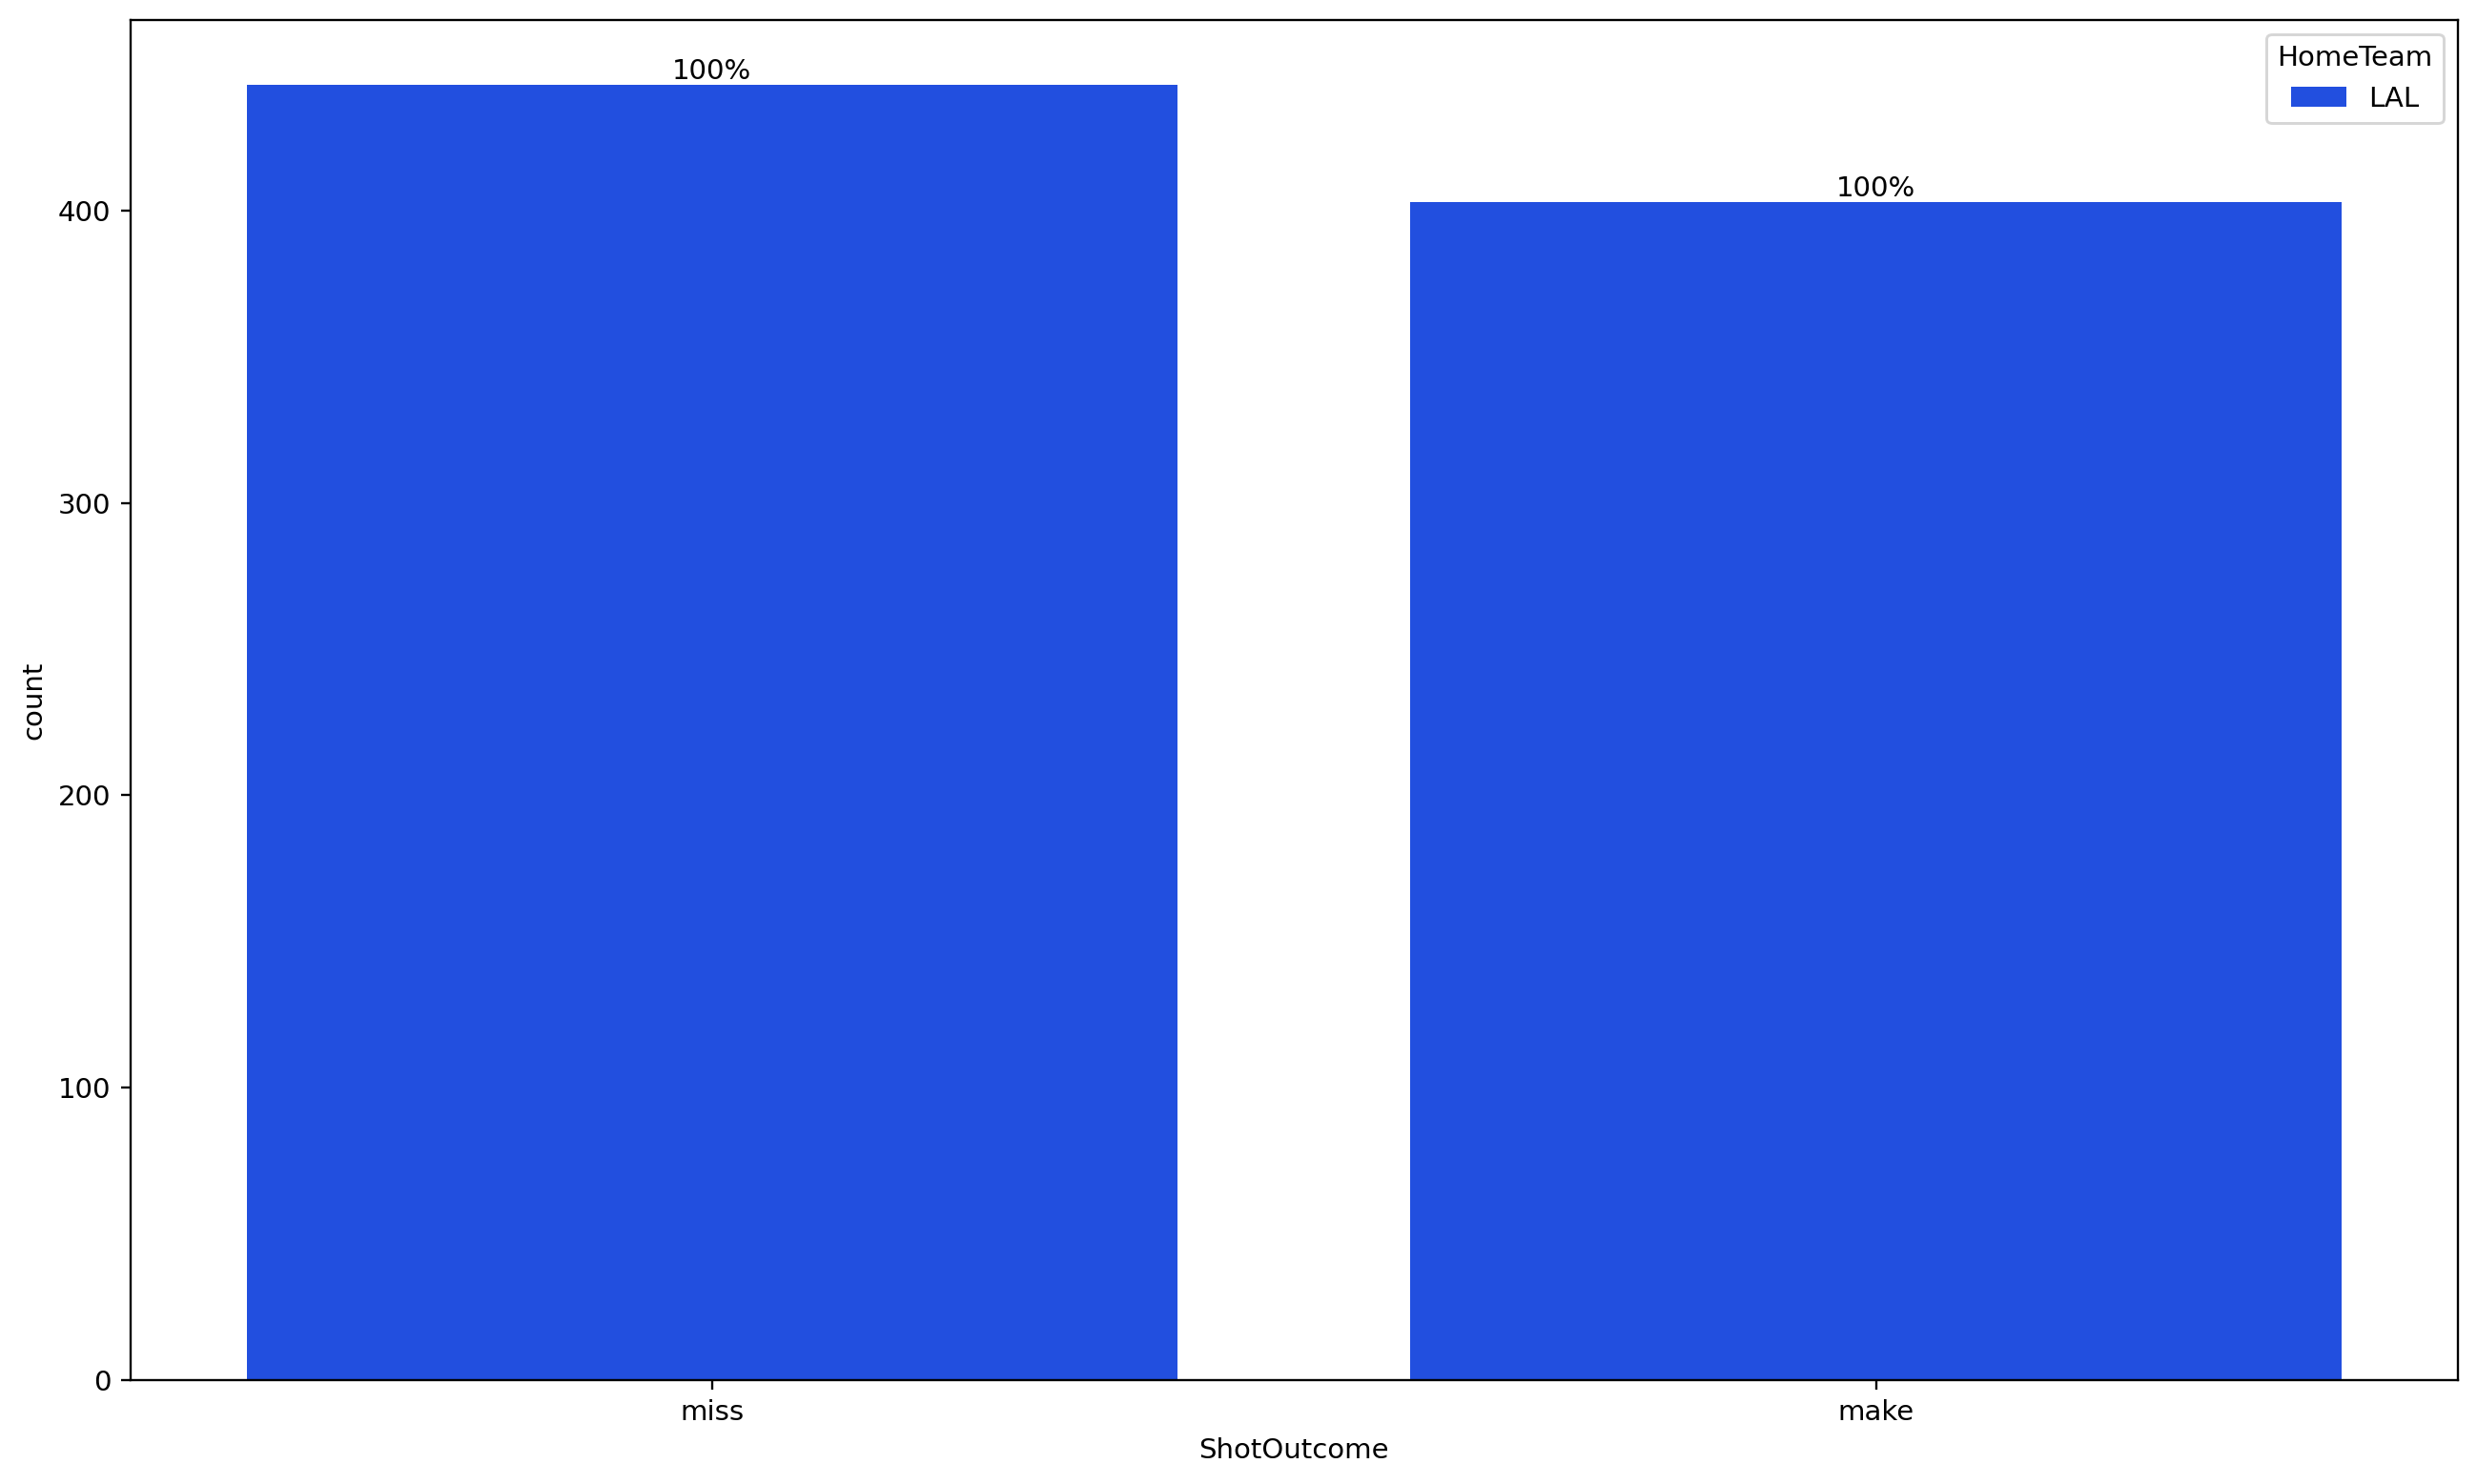

In [11]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='HomeTeam',palette='bright')
barPerc(dfL_LAL,'ShotOutcome',ax)

### De la gráfica anterior, se ve una probabilidad de acierto menor a 0.5 para LAL

## <span style="color:green">Cestas hechas y erradas de los equipos visitantes:

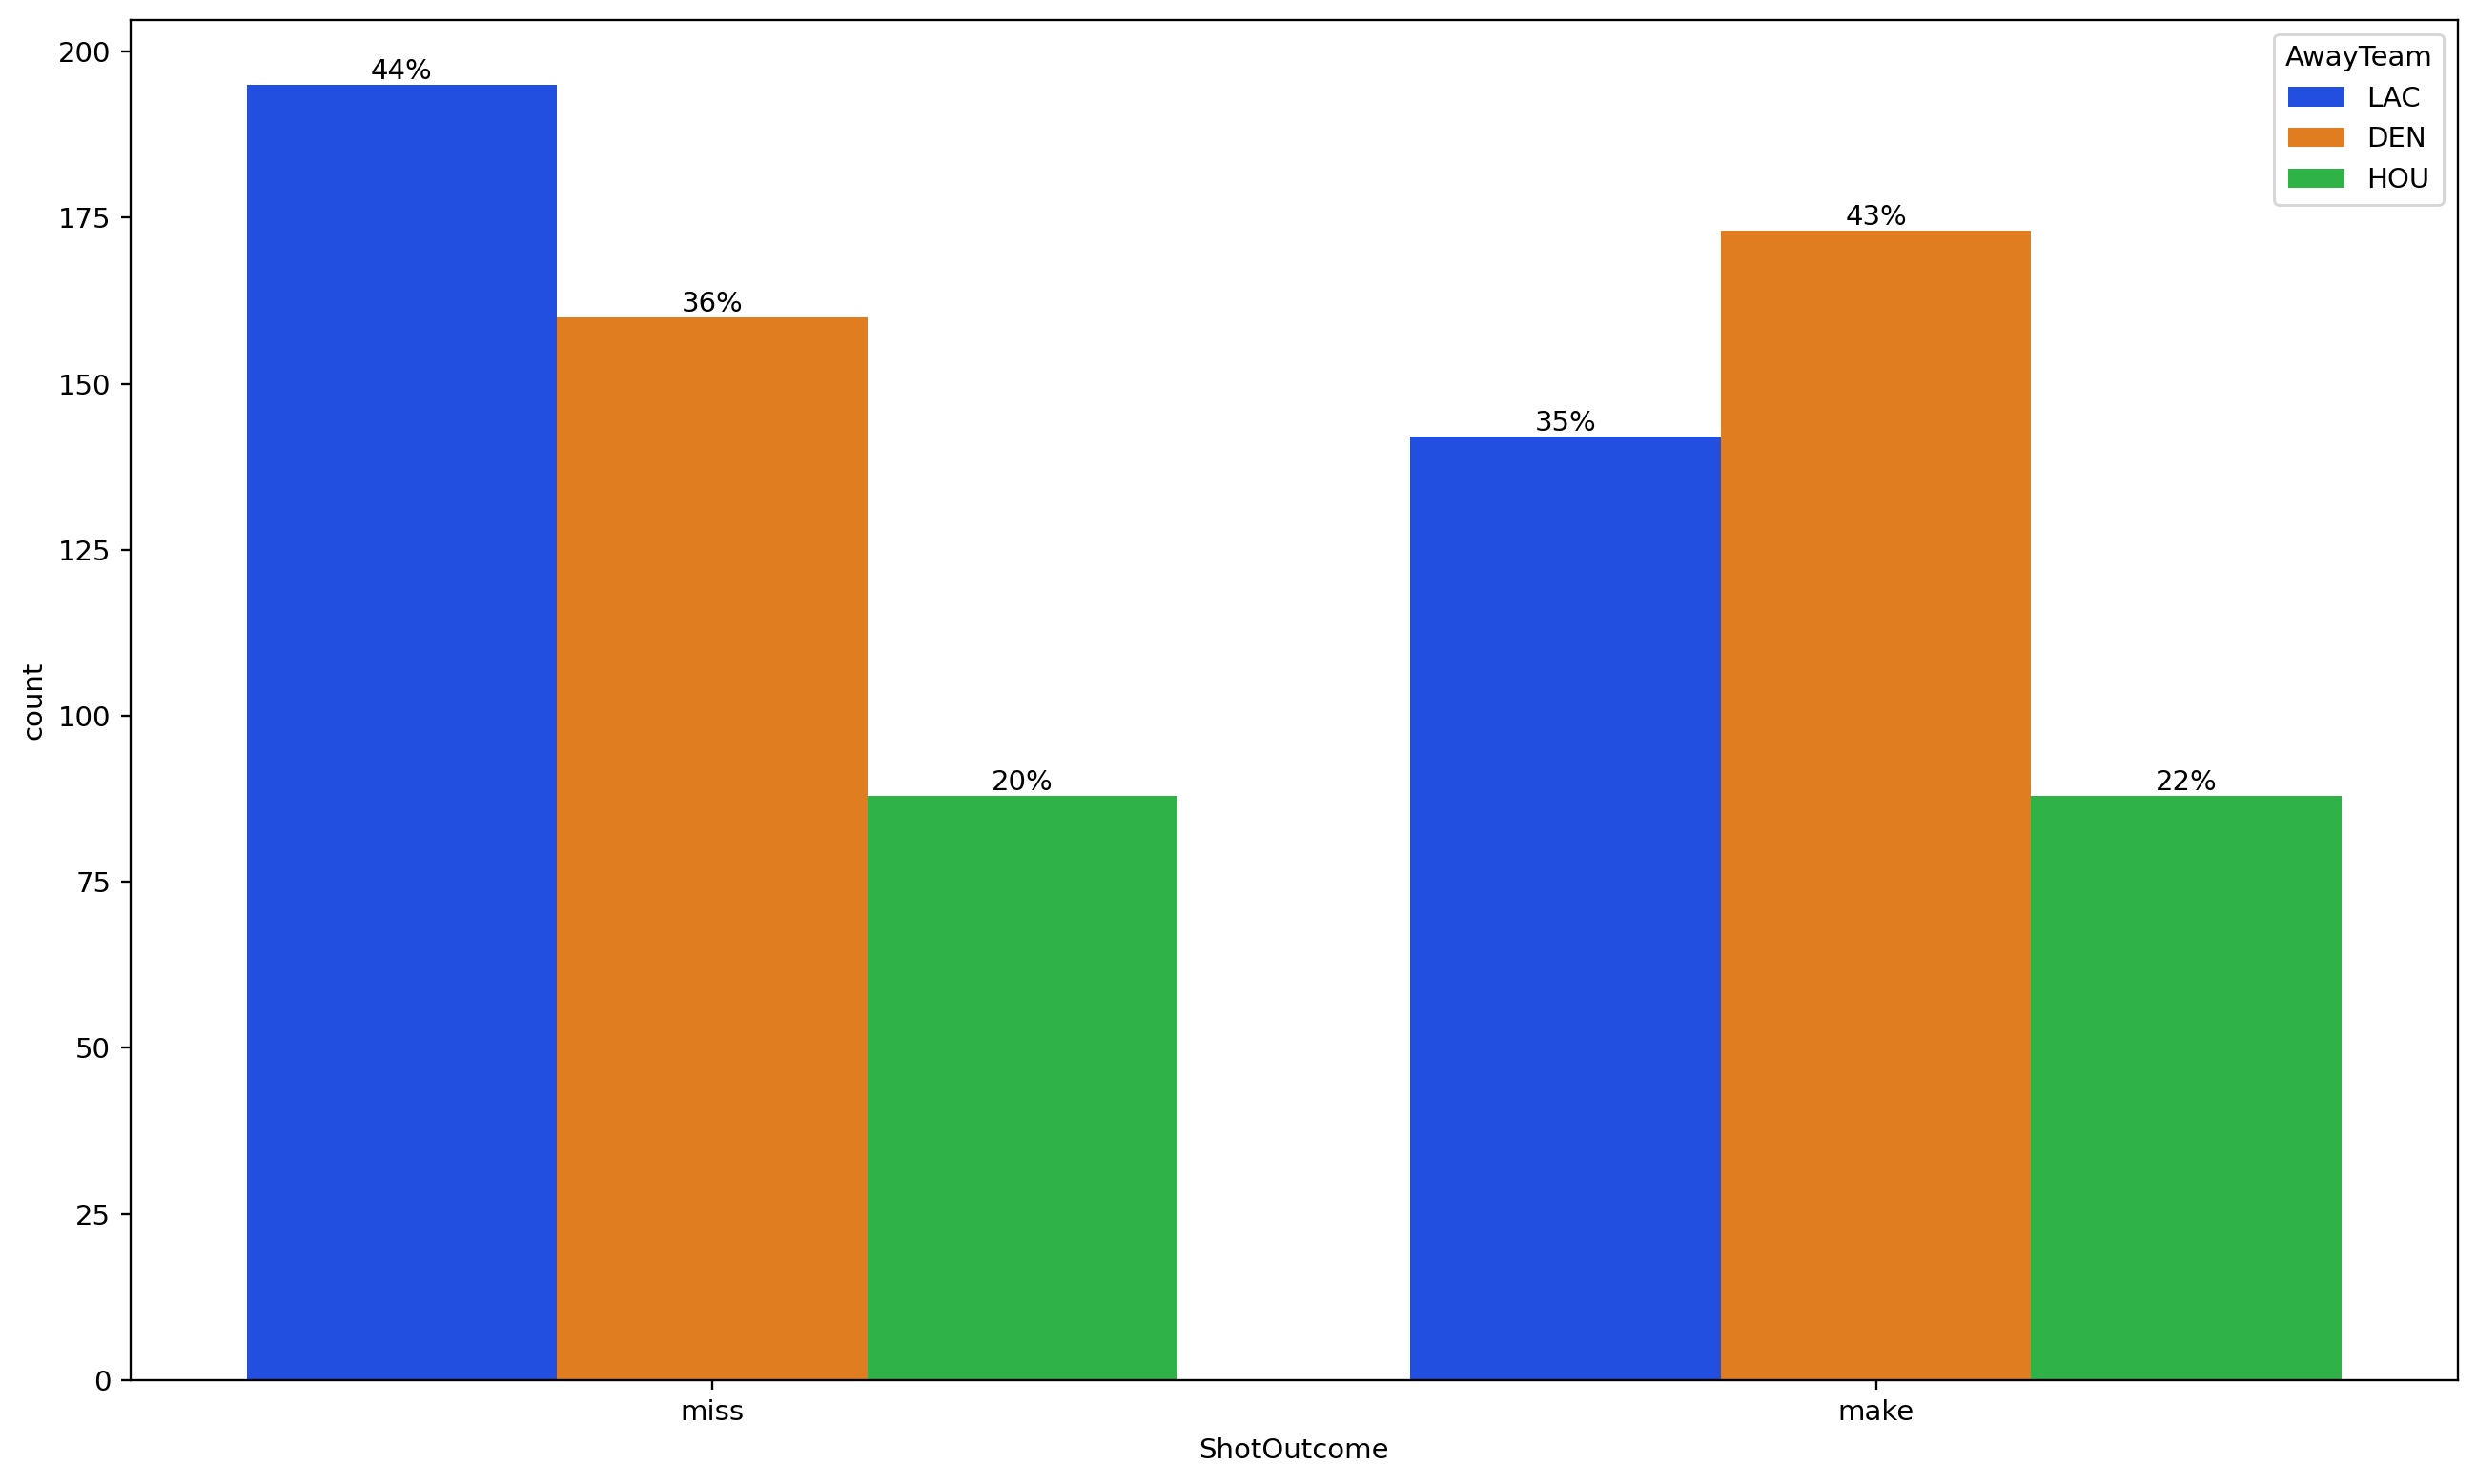

In [12]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='AwayTeam',palette='bright')
barPerc(dfL_LAL,'ShotOutcome',ax)

### De la gráfica anterior, se observa una probabilidad de acierto cercana a 0.5 para HOU, menor a 0.5 para LAC y mayor a 0.5 para DEN.

# <span style="color:blue">Los Angeles Lakers (LAL) de visitante:

In [13]:
dfv_LAL=df[df['AwayTeam']=='LAL']
dfl_LAC=df[df['HomeTeam']=='LAC']
dfl_DEN=df[df['HomeTeam']=='DEN']
dfl_HOU=df[df['HomeTeam']=='HOU']

dfv_LAL_LAC=pd.merge(dfv_LAL, dfl_LAC, how='inner')
dfv_LAL_DEN=pd.merge(dfv_LAL, dfl_DEN, how='inner')
dfv_LAL_HOU=pd.merge(dfv_LAL, dfl_HOU, how='inner')

dfV_LAL1=pd.concat([dfv_LAL_LAC,dfv_LAL_DEN])
dfV_LAL=pd.concat([dfV_LAL1,dfv_LAL_HOU])

num_visitante=dfV_LAL['Date'].nunique()
P_V=dfV_LAL[dfV_LAL['AwayPlay']=='End of Game']['WinningTeam'].mean()

print(f'Hubieron {num_visitante} partidos donde LAL fue visitante y este equipo tuvo un porcentaje de victorias del {np.round(P_V*100,1)}%' )

Hubieron 6 partidos donde LAL fue visitante y este equipo tuvo un porcentaje de victorias del 66.7%


In [14]:
P_acierto_V=dfV_LAL['ShotOutcome'].value_counts().min()/dfV_LAL['ShotOutcome'].value_counts().sum()
print(f'Además, con LAL de visitante, los partidos tuvieron un porcentaje de acierto del {np.round(P_acierto_V*100,1)}% \n' 
      '(considerando cestas hechas y erradas por ambos equipos) ')

Además, con LAL de visitante, los partidos tuvieron un porcentaje de acierto del 45.7% 
(considerando cestas hechas y erradas por ambos equipos) 


## <span style="color:green">Cestas hechas y erradas de los equipos locales:

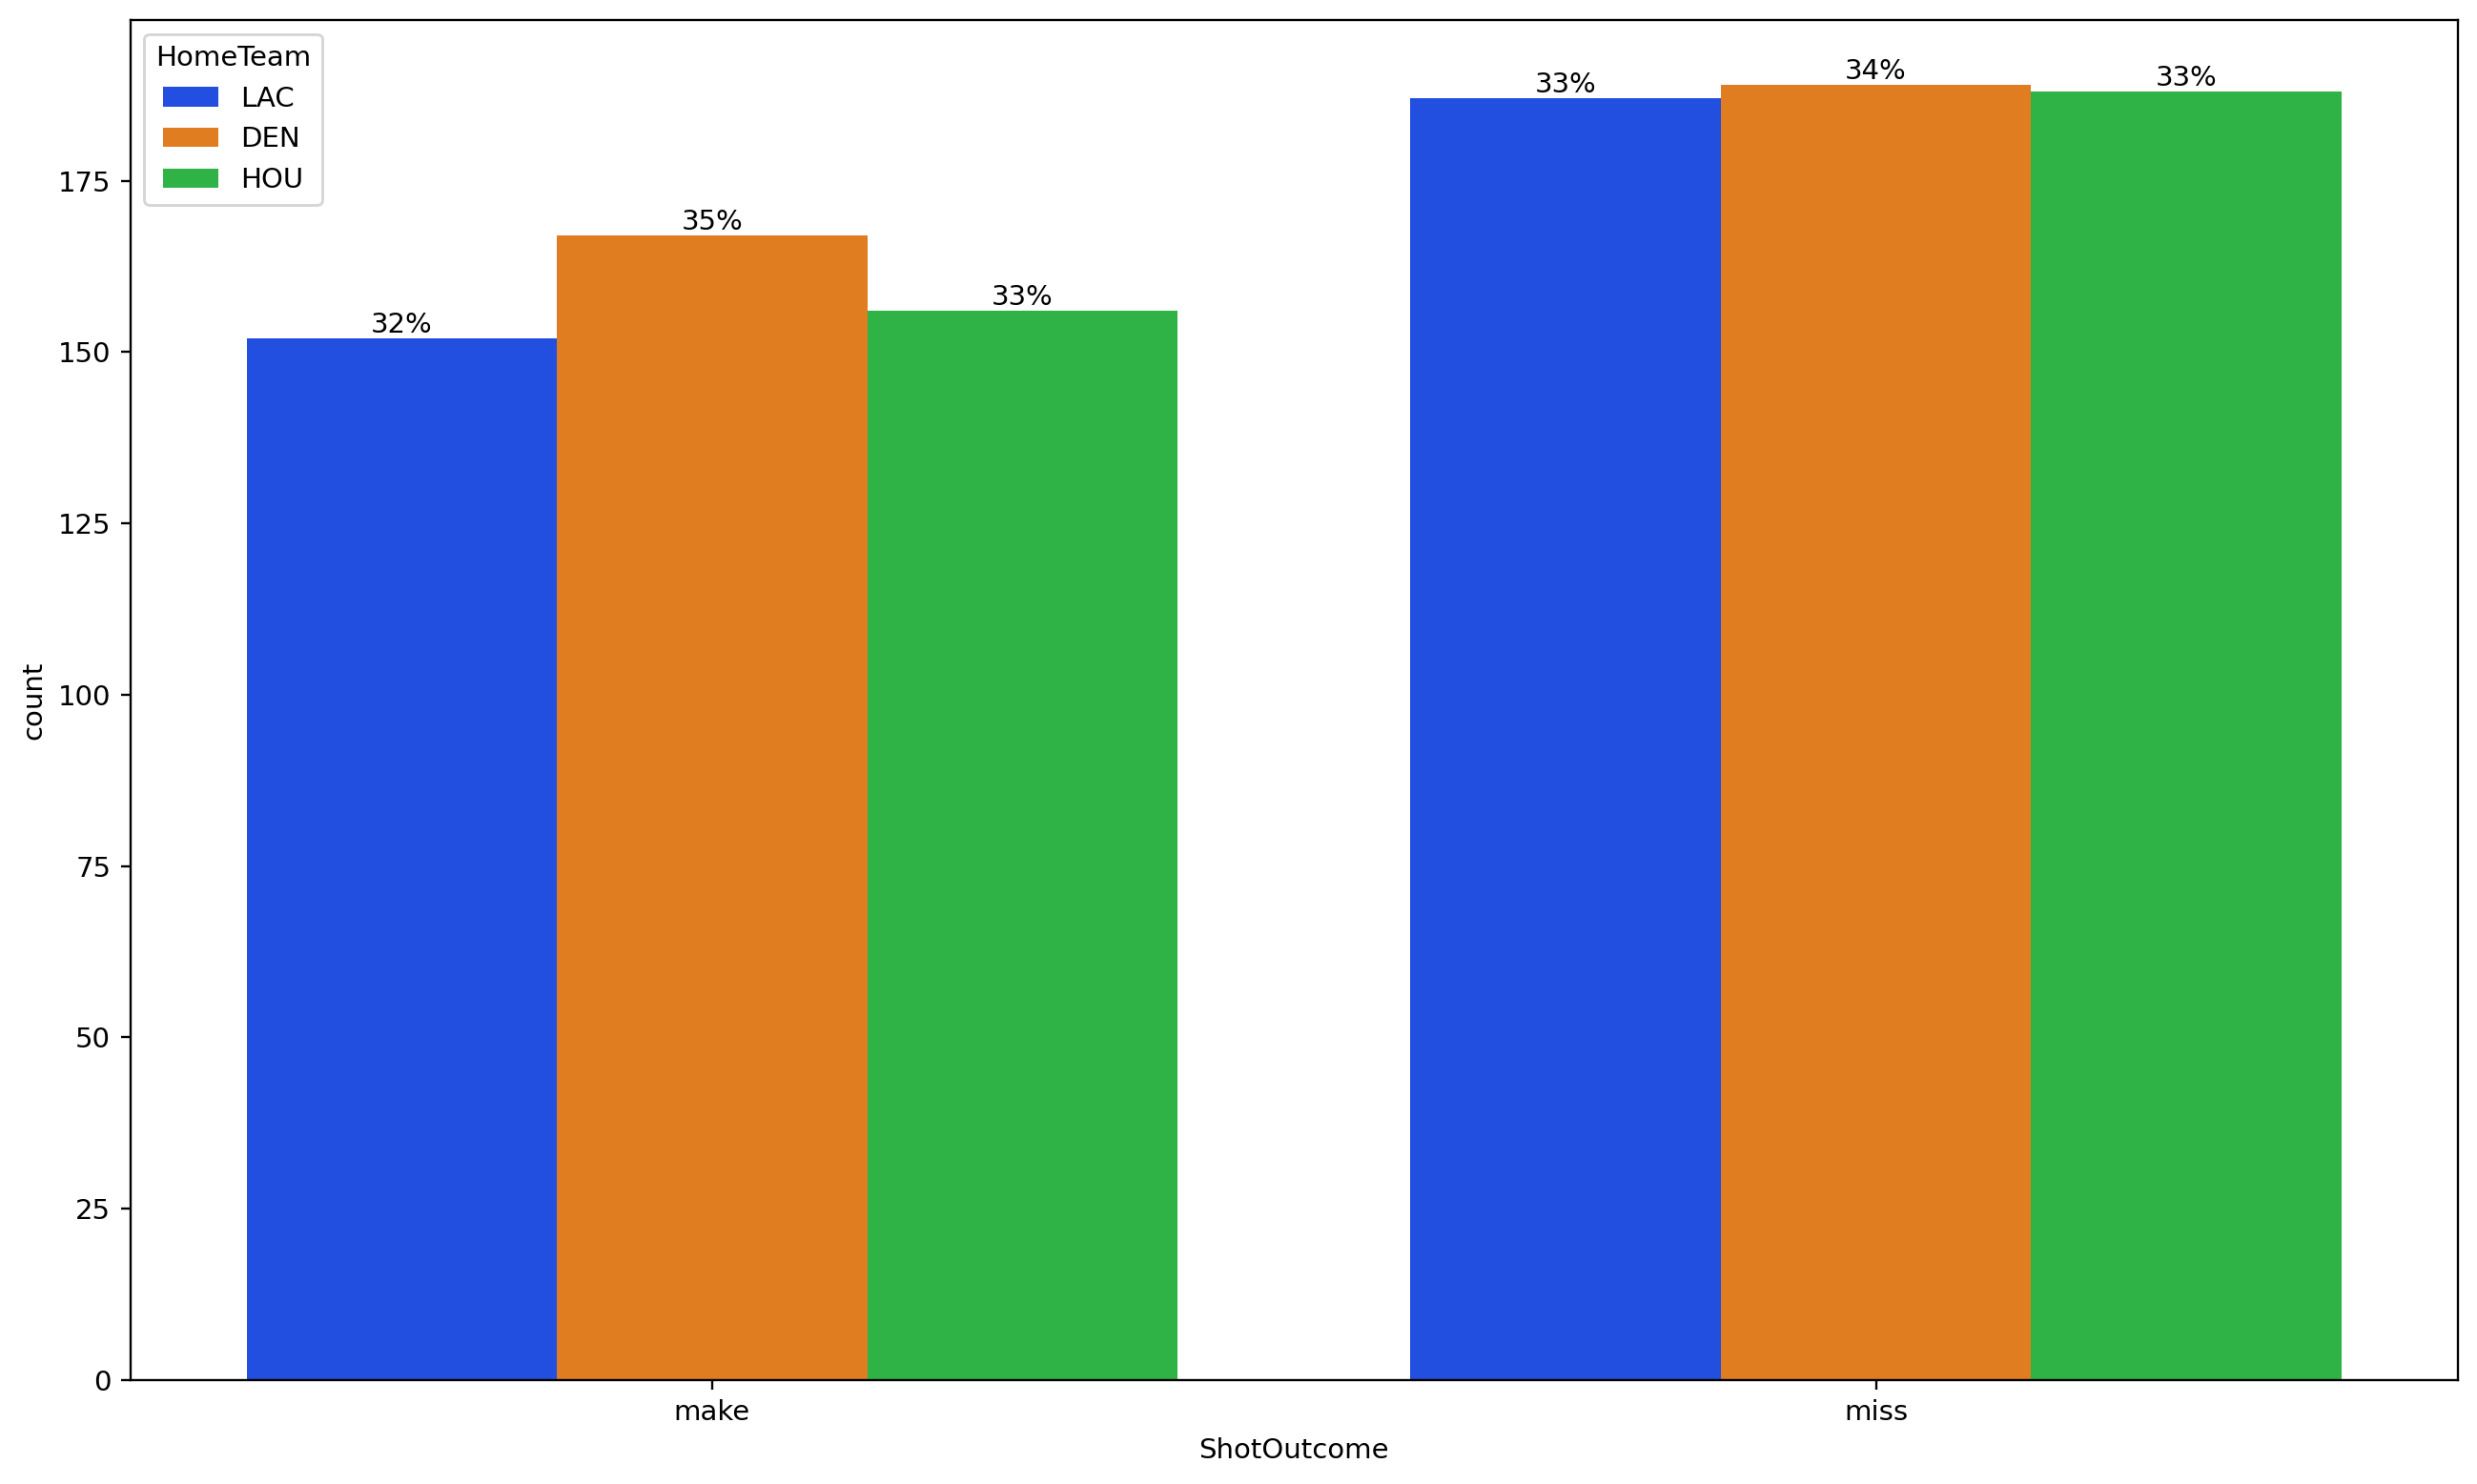

In [15]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfV_LAL,hue='HomeTeam',palette='bright')
barPerc(dfV_LAL,'ShotOutcome',ax)

### De la gráfica anterior, se observa una probabilidad de acierto menor a 0.5 para LAC, DEN y HOU.

## <span style="color:blue">Cestas hechas y erradas del equipo visitante:

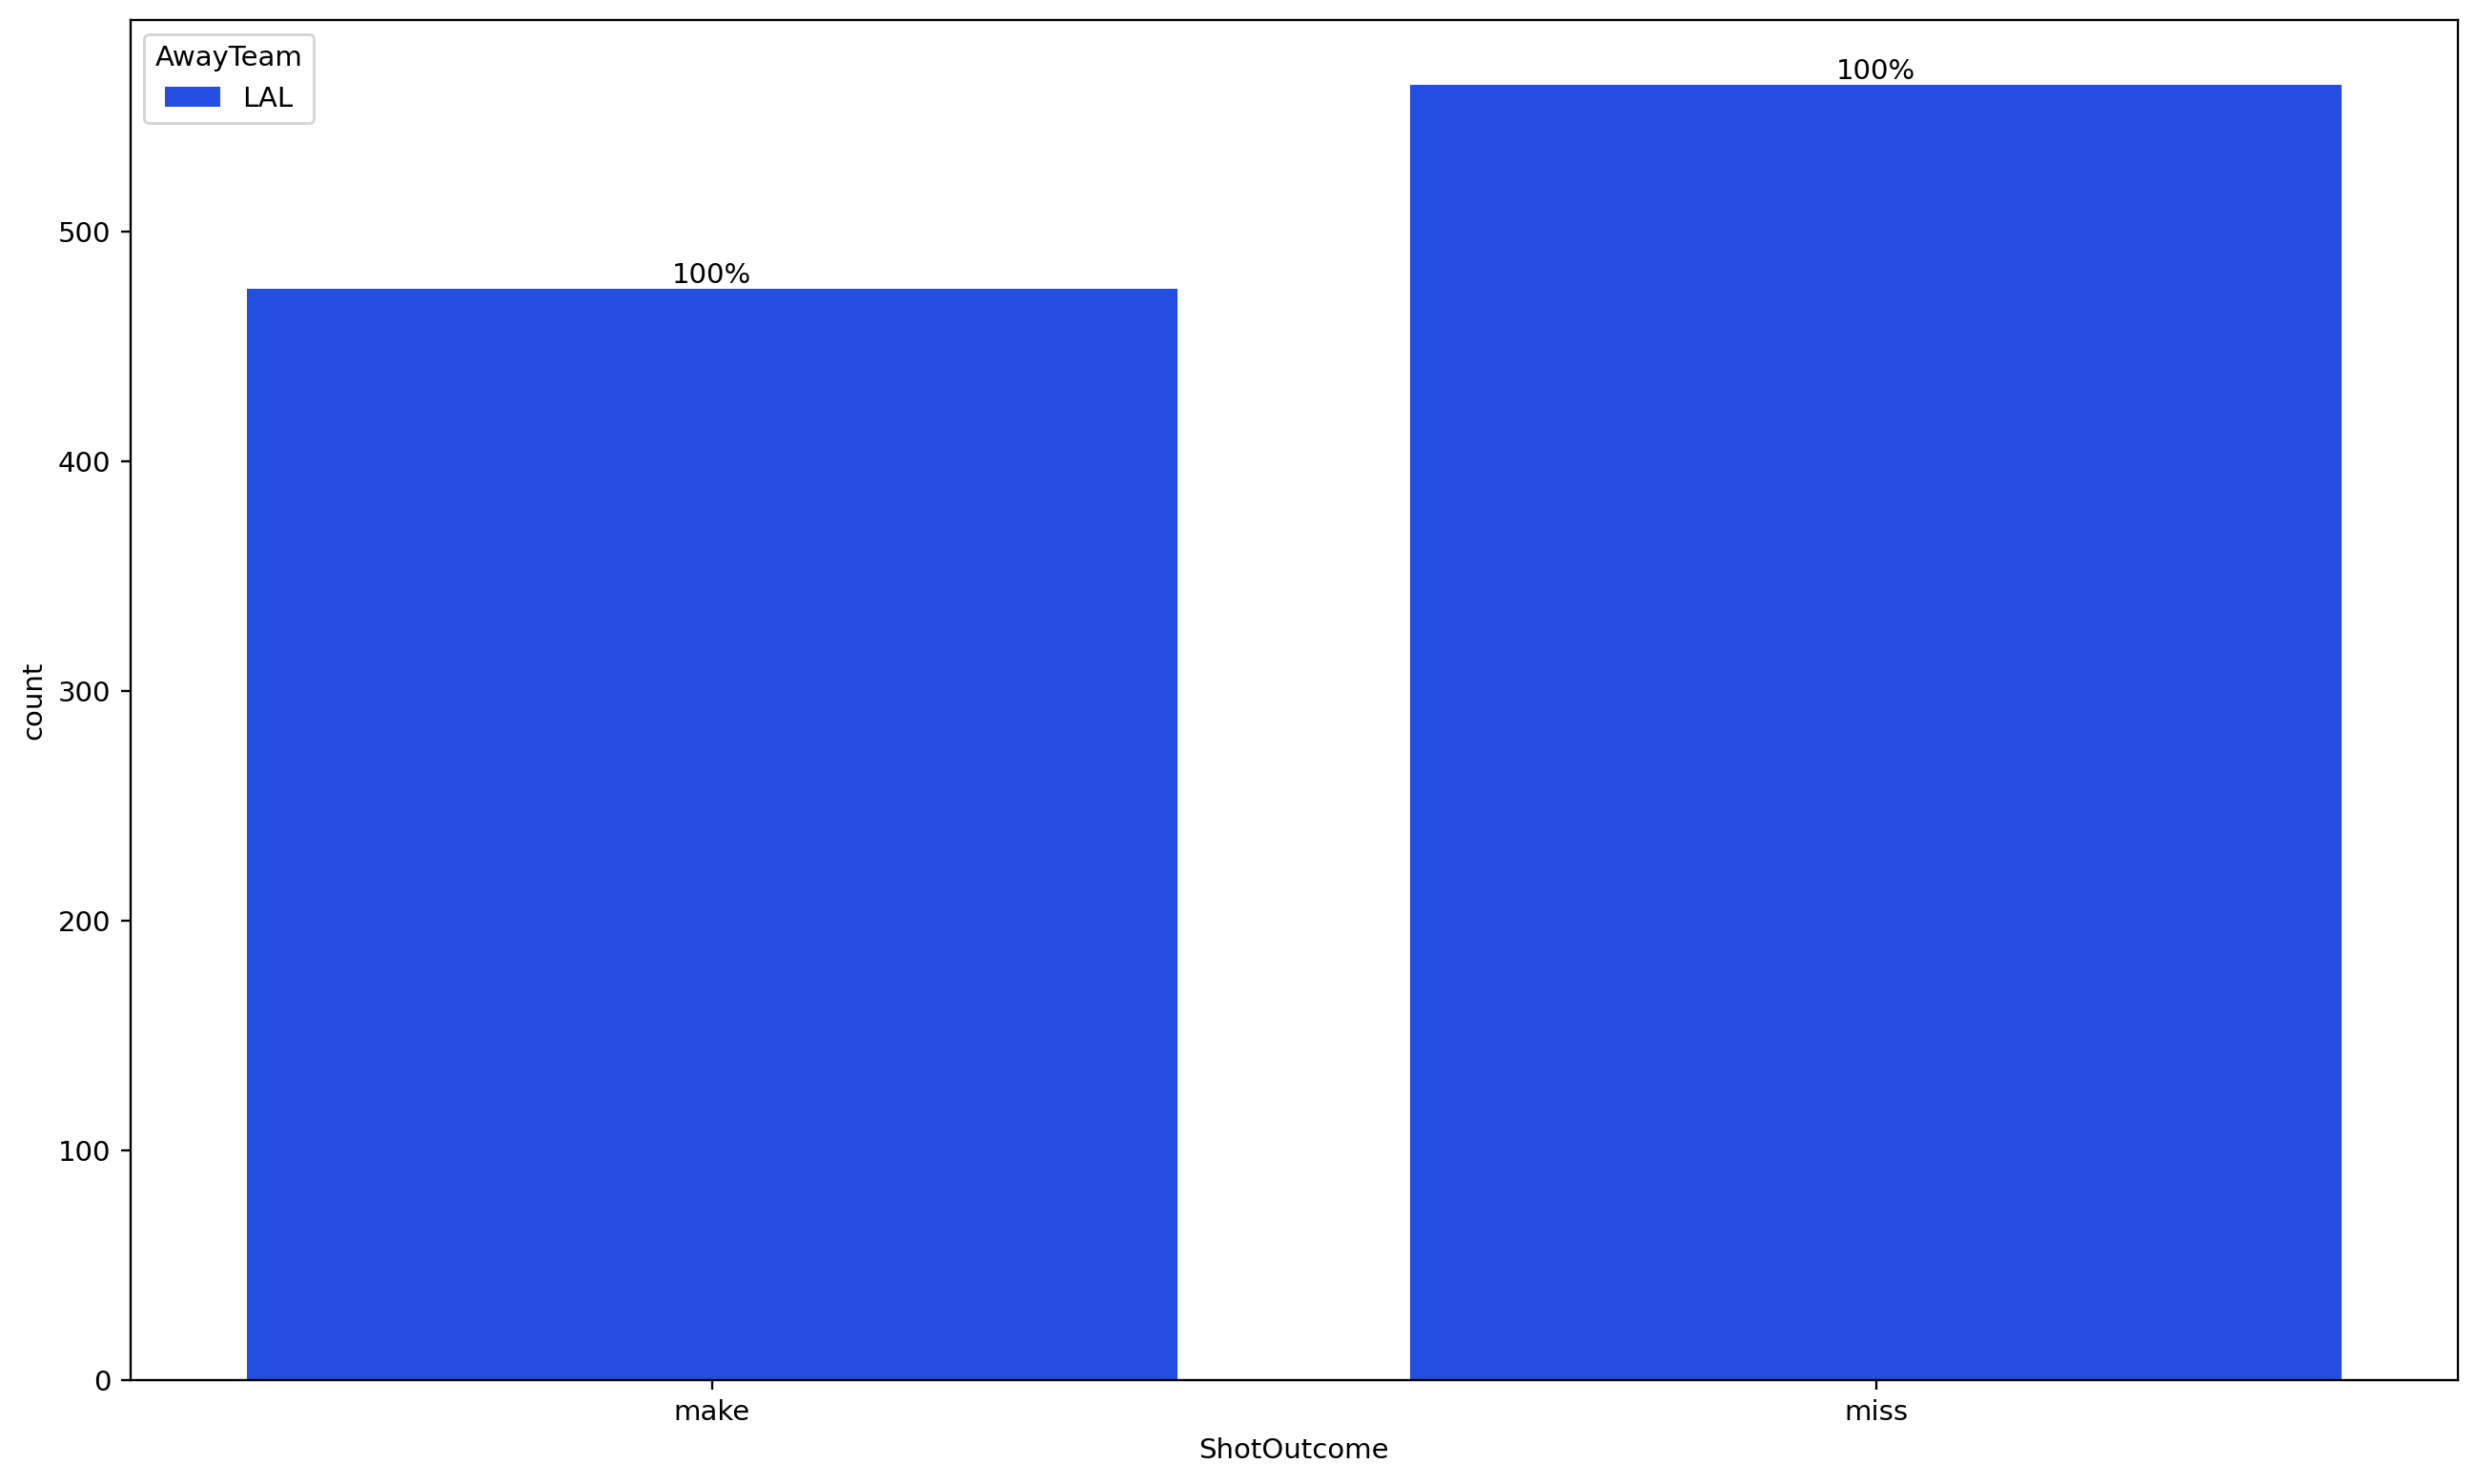

In [16]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfV_LAL,hue='AwayTeam',palette='bright')
barPerc(dfV_LAL,'ShotOutcome',ax)

### De la gráfica anterior, se ve una probabilidad de acierto menor a 0.5 para LAL

# <span style="color:purple">Partidos totales de LAL:

In [17]:
df_LAL=pd.concat([dfL_LAL,dfV_LAL])
df_LAL=df_LAL.reset_index()  #redefiniendo la cuenta del índice de cada fila
df_LAL=df_LAL.drop(columns=['index'])
num=df_LAL['Date'].nunique()
P=df_LAL[df_LAL['AwayPlay']=='End of Game']['WinningTeam'].mean()

print(f'En general, hubieron {num} partidos, donde LAL tuvo un porcentaje de victorias del {np.round(P*100,1)}%' )

En general, hubieron 11 partidos, donde LAL tuvo un porcentaje de victorias del 54.5%


In [18]:
P_acierto=df_LAL['ShotOutcome'].value_counts().min()/df_LAL['ShotOutcome'].value_counts().sum()
print(f'Además, los partidos tuvieron un porcentaje de acierto del {np.round(P_acierto*100,1)}% \n' 
      '(considerando cestas hechas y erradas por ambos equipos) ')

Además, los partidos tuvieron un porcentaje de acierto del 46.6% 
(considerando cestas hechas y erradas por ambos equipos) 


## Viendo la información de todos los partidos de LAL:

In [19]:
df_LAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5265 entries, 0 to 5264
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time         5265 non-null   object
 1   Date         5265 non-null   object
 2   WinningTeam  5265 non-null   object
 3   Quarter      5265 non-null   int64 
 4   SecLeft      5265 non-null   int64 
 5   AwayTeam     5265 non-null   object
 6   AwayPlay     2710 non-null   object
 7   AwayScore    5265 non-null   int64 
 8   HomeTeam     5265 non-null   object
 9   HomePlay     2554 non-null   object
 10  HomeScore    5265 non-null   int64 
 11  ShotType     1885 non-null   object
 12  ShotOutcome  1885 non-null   object
dtypes: int64(4), object(9)
memory usage: 534.9+ KB


## Hallando cuales partidos fueron abiertos y cuales fueron cerrados:

In [20]:
df_dif=df_LAL[df_LAL['AwayPlay']=='End of Game']
df_dif=df_dif.reset_index()  
dif=[]
for i in range(num):
    dif.append(np.abs(df_dif.loc[i,'AwayScore']-df_dif.loc[i,'HomeScore']))
for i in range(num):
    if dif[i]<11:
        print('► El partido con',cyan(df_dif.loc[i,'HomeTeam'],['bold','reverse']), 'de local y',cyan(df_dif.loc[i,'AwayTeam'],['bold','reverse']),'de visitante, disputado en la fecha:',black(df_dif.loc[i,'Date'],['bold','underlined']),'fue un partido', green('cerrado.','bold'),'\n')
    else: 
        print('► El partido con',cyan(df_dif.loc[i,'HomeTeam'],['bold','reverse']), 'de local y',cyan(df_dif.loc[i,'AwayTeam'],['bold','reverse']),'de visitante, disputado en la fecha:',black(df_dif.loc[i,'Date'],['bold','underlined']),'fue un partido', red('abierto.','bold'),'\n')

► El partido con LAL de local y LAC de visitante, disputado en la fecha: December 25 2019 fue un partido cerrado. 

► El partido con LAL de local y LAC de visitante, disputado en la fecha: July 30 2020 fue un partido cerrado. 

► El partido con LAL de local y DEN de visitante, disputado en la fecha: December 22 2019 fue un partido abierto. 

► El partido con LAL de local y DEN de visitante, disputado en la fecha: August 10 2020 fue un partido cerrado. 

► El partido con LAL de local y HOU de visitante, disputado en la fecha: February 6 2020 fue un partido cerrado. 

► El partido con LAC de local y LAL de visitante, disputado en la fecha: October 22 2019 fue un partido cerrado. 

► El partido con LAC de local y LAL de visitante, disputado en la fecha: March 8 2020 fue un partido cerrado. 

► El partido con DEN de local y LAL de visitante, disputado en la fecha: December 3 2019 fue un partido cerrado. 

► El partido con DEN de local y LAL de visitante, disputado en la fecha: February 12 

## Seleccionando únicamente los partidos cerrados:

In [21]:
df1_LAL=df_LAL[df_LAL['Date']!='August 6 2020']
DF_LAL=df1_LAL[df1_LAL['Date']!='December 22 2019']
print('Las fechas de los partidos a usar son:',DF_LAL['Date'].unique())

Las fechas de los partidos a usar son: ['December 25 2019' 'July 30 2020' 'August 10 2020' 'February 6 2020'
 'October 22 2019' 'March 8 2020' 'December 3 2019' 'February 12 2020'
 'January 18 2020']


### Para reordenar el tiempo tal que arranque en 0 y no se reinicie la cuenta en cada cuarto se debe modificar la columna 'SecLeft' tal como se hace a continuación:
### ▲Se parte el dataframe de acuerdo al número de cuartos 
### ▲Recordando que cada cuarto contiene 720 segundos y en total el partido tiene 2880 segundos se realiza la conversión temporal y se normalize tal que el partido empieze en 0 y termine en 1, dicha conversión asegura también que el tiempo se ordene de manera continua durante todo el partido

In [22]:
df_game1=DF_LAL #creando una copia 

In [23]:
df_game11Q=df_game1[df_game1['Quarter']==1] # Haciendo la conversión temporal para el primer cuarto de juego
df_game11Q['SecLeft']=(720-df_game11Q['SecLeft'])/2880

df_game12Q=df_game1[df_game1['Quarter']==2] # Haciendo la conversión temporal para el segundo cuarto de juego
df_game12Q['SecLeft']=(1440-df_game12Q['SecLeft'])/2880

df_game13Q=df_game1[df_game1['Quarter']==3] # Haciendo la conversión temporal para el tercer cuarto de juego
df_game13Q['SecLeft']=(2160-df_game13Q['SecLeft'])/2880

df_game14Q=df_game1[df_game1['Quarter']==4] # Haciendo la conversión temporal para el cuarto cuarto de juego
df_game14Q['SecLeft']=(2880-df_game14Q['SecLeft'])/2880

### Juntando las particiones y conversiones hechas:

In [24]:
df_game1Q=pd.concat([df_game11Q,df_game12Q,df_game13Q,df_game14Q])
df_game1Q=df_game1Q.reset_index()  #redefiniendo la cuenta del índice de cada fila
df_game1Q=df_game1Q.drop(columns=['index'])

## Renombrando la columna 'SecLeft' a 'Sec' (haciendo referencia a segundos transcurridos) y viendo el número de eventos por cada fecha:

In [25]:
df_game1Q=df_game1Q.rename(columns={'SecLeft':'Sec'})
df_game1Q['Date'].value_counts()

January 18 2020     520
March 8 2020        513
July 30 2020        504
December 25 2019    492
December 3 2019     476
October 22 2019     461
February 6 2020     444
February 12 2020    442
August 10 2020      418
Name: Date, dtype: int64

### Dado a la naturaleza de los datos, no se pueden utilizar directamente las columnas de puntajes de cada equipo y hacerlas en función del tiempo ya que habrían bastantes valores repetidos e incoherentes, razón por la cual se añaden unas columnas que hagan la condición de filtrar los puntajes relacionados a su respectivo segundo donde ocurrieron, en otras palabras, lo que se hace es filtrar los puntajes correspondientes a una acción de acierto o 'makes':

In [26]:
#df_game1Q=df_game1Q[df_game1Q['Date']=='October 22 2019'] # para seleccionar un partido en específico cuando sea necesario

In [27]:
df_game1Q['condA']=df_game1Q.AwayPlay.str.contains(r'\w*makes\w*') #A hace referencia a visitante (Away)
df_game1Q['condH']=df_game1Q.HomePlay.str.contains(r'\w*makes\w*') #H hace referencia a local (Home)

In [28]:
#seleccionando únicamente las filas que cumplan cada condición
df_game1QA=df_game1Q[df_game1Q['condA']==True]
df_game1QH=df_game1Q[df_game1Q['condH']==True]

In [29]:
df_game1QA=df_game1QA.reset_index()  #redefiniendo la cuenta del índice de cada fila
df_game1QA=df_game1QA.drop(columns=['index'])

df_game1QH=df_game1QH.reset_index()  #redefiniendo la cuenta del índice de cada fila
df_game1QH=df_game1QH.drop(columns=['index'])

### Creando un objeto Series que represente el puntaje en función del tiempo para cada equipo:

In [30]:
df_game1Qaway=df_game1QA[['Sec','AwayScore']]
df_gameQA= df_game1Qaway.loc[:,'AwayScore']
df_gameQA.index = df_game1Qaway.loc[:,'Sec']

df_game1Qhome=df_game1QH[['Sec','HomeScore']]
df_gameQH= df_game1Qhome.loc[:,'HomeScore']
df_gameQH.index = df_game1Qhome.loc[:,'Sec']

# <span style="color:red">Graficando para los equipos locales:</span> 

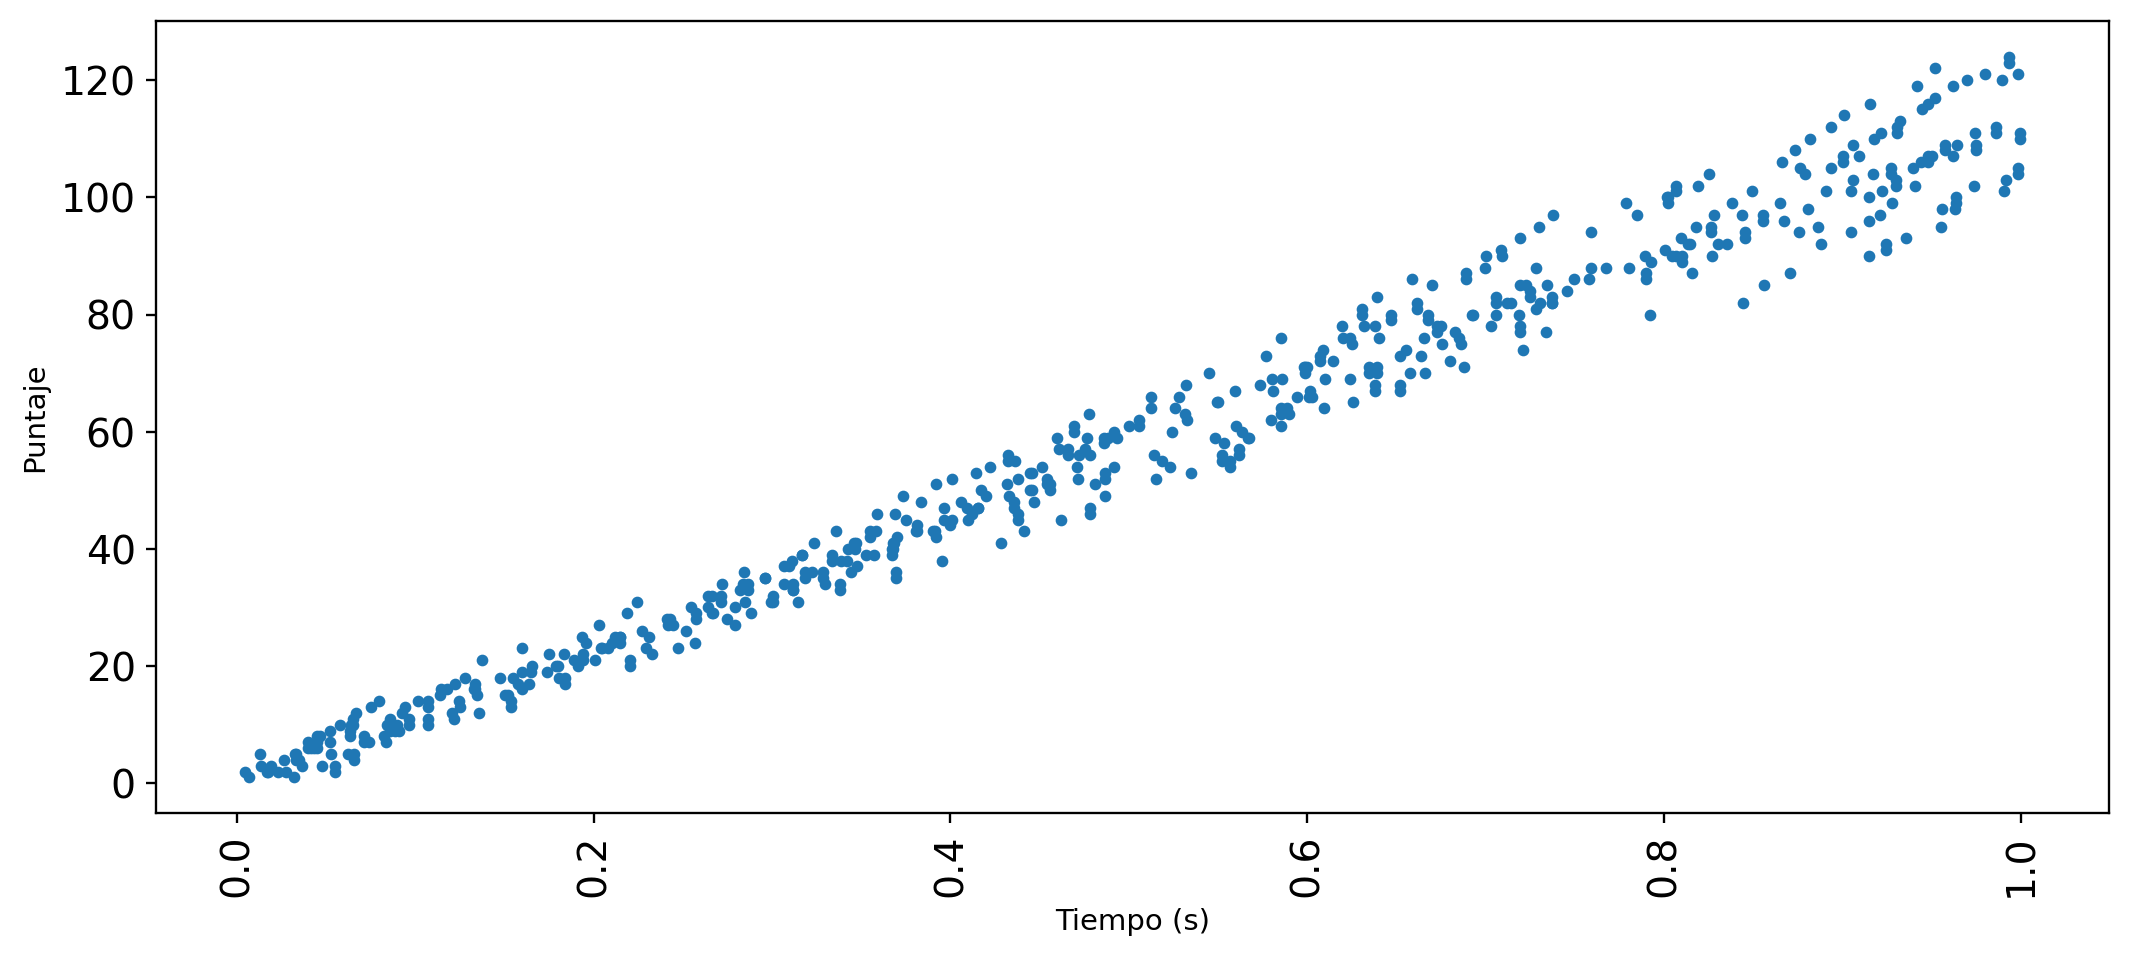

In [31]:
df_gameQA.plot(style='.', xlabel='Tiempo', ylabel='Puntaje',rot=90, figsize = (12, 5), fontsize = 13.5); 

# <span style="color:blue">Graficando para los equipos visitantes:</span> 

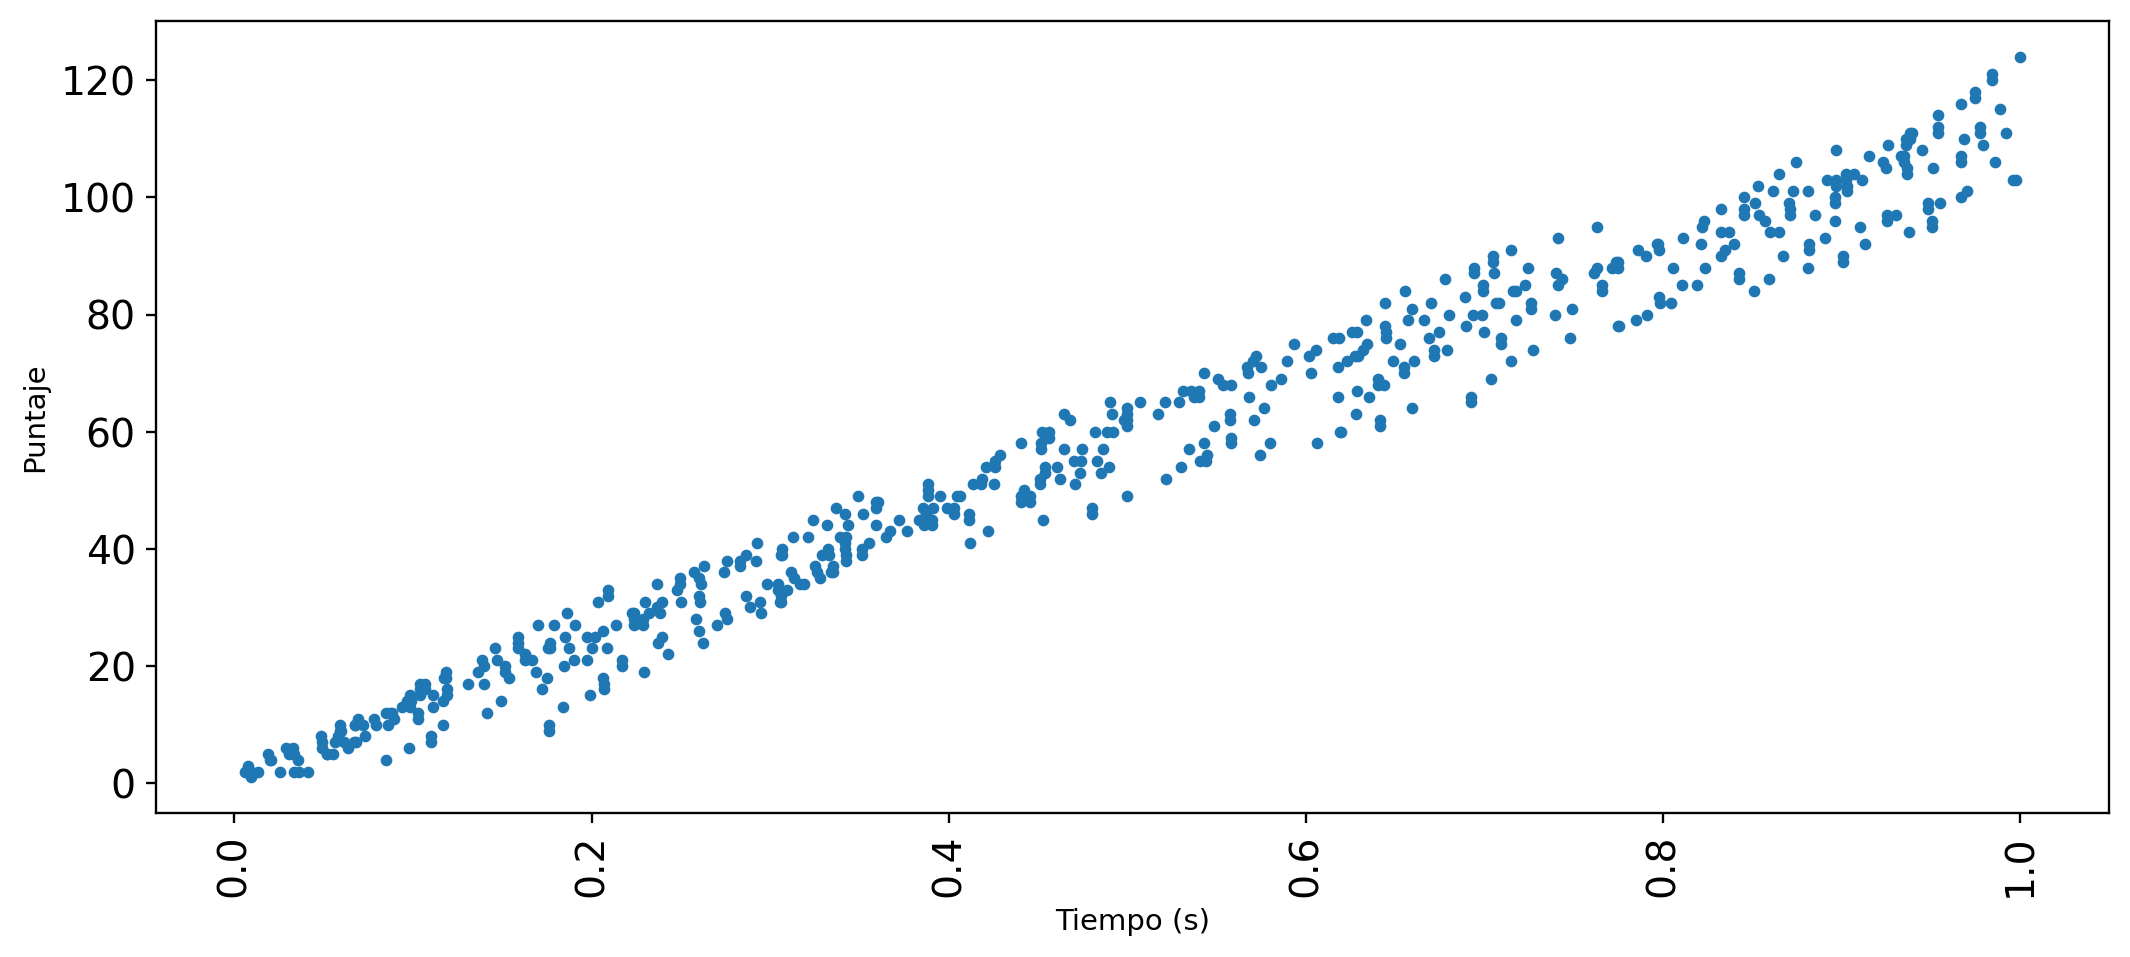

In [32]:
df_gameQH.plot(style='.',rot=90, xlabel='Tiempo', ylabel='Puntaje', figsize = (12, 5), fontsize = 13.5);

## Se selecciona un partido en específico como ejemplo y se busca la diferencia de puntaje en el final de los tres primeros cuartos 

In [33]:
df_ejemplo=df_game1Q[df_game1Q['Date']=='October 22 2019'] 

In [34]:
df_dif1=df_ejemplo[df_ejemplo['AwayPlay']=='End of 1st quarter']
df_dif2=df_ejemplo[df_ejemplo['AwayPlay']=='End of 2nd quarter']
df_dif3=df_ejemplo[df_ejemplo['AwayPlay']=='End of 3rd quarter']
df_dif=pd.concat([df_dif1,df_dif2,df_dif3])
dif=np.zeros(3)
for i in range(3):
    dif[i]=(df_dif.iloc[i]['HomeScore']-df_dif.iloc[i]['AwayScore'])
    print('La diferencia de puntos en el cuarto número',magenta(i+1,['bold','underlined']),'fue de',int(dif[i]),'puntos.')
    

La diferencia de puntos en el cuarto número 1 fue de -3 puntos.
La diferencia de puntos en el cuarto número 2 fue de 8 puntos.
La diferencia de puntos en el cuarto número 3 fue de 0 puntos.


# <span style="color:orange">Método Newton Rhapson - Mathematica:</span> 

In [35]:
def f(x): #función a la cual se le busca hallar la raíz
    return np.sin(x)-x+3/2
def df(x):#derivada numérica de la función
    h=10**(-8) 
    return (f(x+h)-f(x))/h

In [36]:
a,b,error,i,MaxIter=2,3,1,1,100 #parámetros a usar
x0=(a+b)/2 #punto medio del intervalo a usar
while error>10**(-6) and i<MaxIter:
    x1=x0-f(x0)/df(x0)
    error=np.abs(x1-x0)
    x0=x1
    print('Iteración',i,f'x={x0}',f' con error igual a {error}')
    i=i+1

Iteración 1 x=2.2770706021645397  con error igual a 0.22292939783546029
Iteración 2 x=2.267194674741264  con error igual a 0.009875927423275588
Iteración 3 x=2.26717200878221  con error igual a 2.266595905409119e-05
Iteración 4 x=2.2671720086619325  con error igual a 1.202775656850008e-10
